#### Database

In [1]:
PROJECT_PATH = '/home/md/Work/ligalytics/leagues_stable/'
import os, sys
sys.path.insert(0, PROJECT_PATH)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "leagues.settings")

from leagues import settings
settings.DATABASES['default']['NAME'] = PROJECT_PATH+'/db.sqlite3'

import django
django.setup()

from scheduler.models import *
from common.functions import distanceInKmByGPS
season = Season.objects.filter(nicename="Imported: Benchmark Season").first()
import pandas as pd
import numpy as np
from django.db.models import F
games = Game.objects.filter(season=season)
df = pd.DataFrame.from_records(games.values())
games = Game.objects.filter(season=season).annotate(
    home=F('homeTeam__shortname'),
    away=F('awayTeam__shortname'),
    home_lat=F('homeTeam__latitude'),
    home_lon=F('homeTeam__longitude'),
    home_attr=F('homeTeam__attractivity'),
    away_lat=F('awayTeam__latitude'),
    away_lon=F('awayTeam__longitude'),
    away_attr=F('awayTeam__attractivity'),
    home_country=F('homeTeam__country'),
    away_country=F('awayTeam__country'),
).values()



#### Dataframe

In [2]:
from sklearn.preprocessing import OneHotEncoder

# create dataset
df = pd.DataFrame.from_records(games.values())

# data cleaning
df['time'] = df['time'].replace('','0')
df = df[df['attendance'] != 0]


# pivots
pivot_homeTeam_mean = df.pivot_table('attendance','homeTeam_id',aggfunc='mean')
pivot_homeTeam_max = df.pivot_table('attendance','homeTeam_id',aggfunc='max')

# add more features
df['weekday'] = df.apply(lambda r: r['date'].weekday(), axis=1)
df['day'] = df.apply(lambda r: r['date'].day, axis=1)
df['month'] = df.apply(lambda r: r['date'].month, axis=1)
df['year'] = df.apply(lambda r: r['date'].year, axis=1)
df['distance'] = df.apply(lambda r: distanceInKmByGPS(r['home_lon'],r['home_lat'],r['away_lon'],r['away_lat']), axis=1)
df['weekend'] = df.apply(lambda r: int(r['weekday'] in [6,7]), axis=1)
df['winter_season'] = df.apply(lambda r: int(r['month'] in [1,2,3,10,11,12]), axis=1)
df['home_base'] = df.apply(lambda r: pivot_homeTeam_mean.loc[r['homeTeam_id'],'attendance'], axis=1)
df['stadium_size'] = df.apply(lambda r: pivot_homeTeam_max.loc[r['homeTeam_id'],'attendance'], axis=1)
df['early'] = df.apply(lambda r: r['time'].replace(':','') < "1800", axis=1)
df['before2010'] = df.apply(lambda r: r['historic_season'].split('-')[0] < "2010", axis=1)


# one hot encoding
ohe_fields = ['home_country']

for field in ohe_fields:
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(df[[field]])
    df[ohe.categories_[0]] = transformed.toarray()

# sort label to last index
cols = list(df.columns)
cols.append(cols.pop(cols.index('attendance')))
df = df[cols]

#### Train/Test Data - Normalization

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor


remove_columns = ['season_id', 'resultEntered', 'reversible', 'reschedule', 'homeGoals', 'awayGoals',
                  'homeGoals2', 'awayGoals2', 'homeGoals3', 'awayGoals3', 'home', 'away', 'date', 'time',
                  'id', 'homeTeam_id', 'awayTeam_id', 'historic_season',
                  'home_country','home_lat','home_lon','away_lat','away_lon','away_country']
feature_cols = list(set(df.columns[:-1]) - set(remove_columns))
# feature_cols = ['weekday','weekend','home_base','distance','winter_season']
label = 'attendance'


X = df[feature_cols]  # Features
y = df[label]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

In [4]:
import os
import pandas as pd
from pandas import DataFrame,Series
from sklearn import tree
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model

In [7]:
X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)

In [8]:
number_of_samples = len(y_train)
np.random.seed(0)
random_indices = np.random.permutation(number_of_samples)
num_training_samples = int(number_of_samples*0.75)
x_train = X_Train[random_indices[:num_training_samples]]
y_train=y[random_indices[:num_training_samples]]
x_test=X_Train[random_indices[num_training_samples:]]
y_test=y[random_indices[num_training_samples:]]
y_Train=list(y_train)

In [9]:
model=linear_model.Ridge()
model.fit(x_train,y_train)
y_predict=model.predict(x_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_ridge=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_ridge)+" percent in Ridge Regression")

Y_test=model.predict(x_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_ridge=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_ridge)+" percent in Ridge Regression")

Train error = 98.11885891315514 percent in Ridge Regression
Test error = 100.86230814227264 percent in Ridge Regression


Text(0.5, 1.0, 'Residual plot in Ridge Regression')

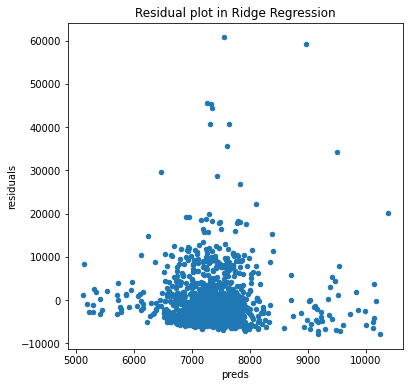

In [12]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Ridge Regression")

In [10]:
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(x_train,y_train)
y1_knn=knn.predict(x_train)
y1_knn=list(y1_knn)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_knn[i]-y_Train[i])/y_Train[i])
train_error_knn=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_knn)+" percent"+" in Knn algorithm")

y2_knn=knn.predict(x_test)
y2_knn=list(y2_knn)
error=0
for i in range(len(y_test)):
    error+=(abs(y2_knn[i]-Y_test[i])/Y_test[i])
test_error_knn=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_knn)+" percent"+" in knn algorithm")

Train error = 86.04732435905834 percent in Knn algorithm
Test error = 29.305494469835775 percent in knn algorithm


Text(0.5, 1.0, 'Residual plot in Knn')

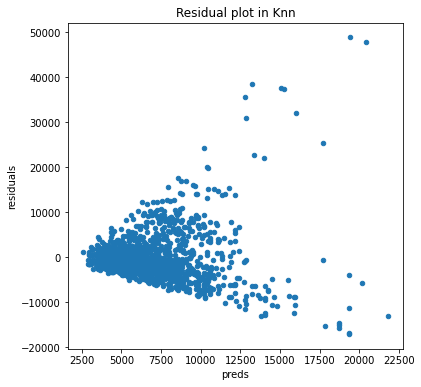

In [11]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Knn")

In [13]:
reg = linear_model.BayesianRidge()
reg.fit(x_train,y_train)
y1_reg=reg.predict(x_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(x_test)
y2_reg=list(y2_reg)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_reg[i]-y_Train[i])/y_Train[i])
train_error_bay=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_bay)+" percent"+" in Bayesian Regression")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_reg[i]-Y_test[i])/Y_test[i])
test_error_bay=(error/len(Y_test))*100
print("Test error = "+'{}'.format(test_error_bay)+" percent"+" in Bayesian Regression")

Train error = 98.41770536088067 percent in Bayesian Regression
Test error = 6.2704745296132876 percent in Bayesian Regression


Text(0.5, 1.0, 'Residual plot in Bayesian Regression')

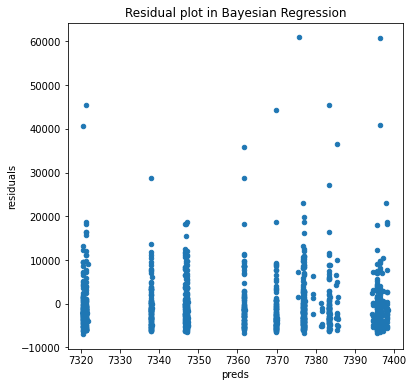

In [14]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":reg.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

In [16]:
dec = tree.DecisionTreeRegressor(max_depth=1)
dec.fit(x_train,y_train)
y1_dec=dec.predict(x_train)
y1_dec=list(y1_dec)
y2_dec=dec.predict(x_test)
y2_dec=list(y2_dec)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_dec[i]-y_Train[i])/y_Train[i])
train_error_tree=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_tree)+" percent"+" in Decision Tree Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y1_dec[i]-Y_test[i])/Y_test[i])
test_error_tree=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_tree)+" percent in Decision Tree Regressor")

Train error = 98.15574267963966 percent in Decision Tree Regressor
Test error = 7.1677452486549855 percent in Decision Tree Regressor


Text(0.5, 1.0, 'Residual plot in Decision Tree')

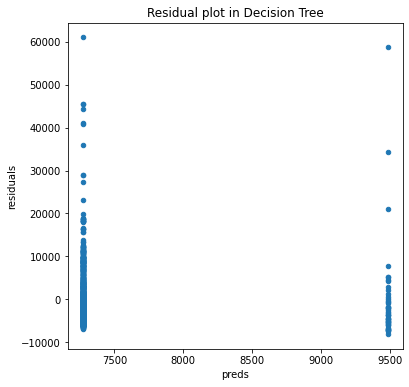

In [17]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":dec.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Decision Tree")

In [18]:
svm_reg=svm.SVR()
svm_reg.fit(x_train,y_train)
y1_svm=svm_reg.predict(x_train)
y1_svm=list(y1_svm)
y2_svm=svm_reg.predict(x_test)
y2_svm=list(y2_svm)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_svm[i]-y_Train[i])/y_Train[i])
train_error_svm=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_svm)+" percent"+" in SVM Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_svm[i]-Y_test[i])/Y_test[i])
test_error_svm=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_svm)+" percent in SVM Regressor")

Train error = 73.1224560206315 percent in SVM Regressor
Test error = 21.522381238558573 percent in SVM Regressor


Text(0.5, 1.0, 'Residual plot in SVM')

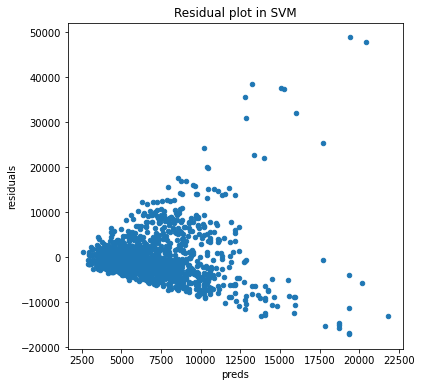

In [19]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in SVM")

In [20]:
train_error=[train_error_ridge,train_error_knn,train_error_bay,train_error_tree,train_error_svm]
test_error=[test_error_ridge,test_error_knn,test_error_bay,test_error_tree,test_error_svm]

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Knn','Bayesian Regression','Decision Tree','SVM']
df=DataFrame(data=col,index=models)
df

Train Error  Test Error
Ridge Regression       98.118859  100.862308
Knn                    86.047324   29.305494
Bayesian Regression    98.417705    6.270475
Decision Tree          98.155743    7.167745
SVM                    73.122456   21.522381